In [1]:
import os
import tomllib
from copy import deepcopy

import dill
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt
from numpyro.infer import MCMC, NUTS
from tqdm.auto import tqdm
from jaxted.numpyro import jaxted_inputs_from_numpyro
from jaxted.nest import run_nest

%matplotlib inline

In [2]:
from burst import construct_numpyro_model, create_jaxted_arguments
from utils import approximate_divergence, segment_times

In [3]:
config = tomllib.load(open("sinegaussian_selection.toml", "rb"))

bounds = config["bounds"]
duration = config["duration"]
sample_rate = config["sample_rate"]

times = segment_times(duration, sample_rate)
phase_marginalization = config["hba"].pop("phase_marginalization", False)


# numpyro_model = construct_numpyro_model(
#     duration,
#     sample_rate,
#     bounds.copy(),
#     phase_marginalization=config["hba"].pop("phase_marginalization", False),
# )

In [9]:
from functools import partial

rng_key = jax.random.PRNGKey(10)

true_sigma = 0.65

with open(f"events_{true_sigma}_0.pkl", "rb") as f:
    events = dill.load(f)[:]

with open(f"params_{true_sigma}_0.pkl", "rb") as f:
    params = dill.load(f)

all_fpeak_posteriors = list()

# _likelihood_fn, _ln_prior_fn, _sample_fn, boundary_fn = jaxted_inputs_from_numpyro(
#     numpyro_model
# )

bds = deepcopy(bounds)
bds["frequency"][1] = true_sigma

_likelihood_fn, _ln_prior_fn, _sample_fn, boundary_fn = create_jaxted_arguments(
    duration, sample_rate, bds.copy(), phase_marginalization=phase_marginalization
)


with jax.log_compiles():
# with jax.explain_cache_misses():
    for event in tqdm(events[:100]):
        
        # likelihood_fn = partial(_likelihood_fn, event=event)
        # ln_prior_fn = partial(_ln_prior_fn, event=event)
        # sample_fn = partial(_sample_fn, event=event)

        rng_key, temp = jax.random.split(rng_key)

        _, _, samples = run_nest(
            likelihood_fn=_likelihood_fn, ln_prior_fn=_ln_prior_fn, sample_prior=_sample_fn,
            boundary_fn=boundary_fn,
            sub_iterations=15,
            nsteps=20,
            nlive=250,
            rseed=jax.random.randint(temp, (), 0, 2**32 - 1),
            event=event,
        )
        ln_weights = samples["ln_weights"]
        ln_weights -= np.max(ln_weights)
        keep = ln_weights > np.log(jax.random.uniform(rng_key, ln_weights.shape))
        idxs = jax.random.choice(rng_key, len(keep), (500,), replace=False, p=keep)
        # samples = {key: values[keep] for key, values in samples.items()}

        all_fpeak_posteriors.append(samples["frequency"][idxs])

all_fpeak_posteriors

  0%|          | 0/100 [00:00<?, ?it/s]

[Array([5.04319315, 4.9922958 , 5.27732328, 5.09250662, 5.22413657,
        5.19191652, 5.25108223, 5.12991298, 5.21091861, 5.229839  ,
        5.09221292, 5.04172275, 5.16913793, 5.16549638, 5.16891292,
        5.24372303, 5.14438123, 5.15530481, 5.01940662, 5.24025775,
        5.16932886, 5.15966319, 5.17301315, 5.06827219, 5.31222907,
        5.07396698, 5.16508191, 5.16692332, 5.15833341, 4.99848293,
        5.15109899, 5.20953378, 5.07643437, 5.14516541, 5.16961488,
        5.10595038, 5.06703086, 5.19820668, 5.05596836, 5.04339991,
        5.10404553, 5.05671335, 5.13761113, 5.16005737, 5.0847864 ,
        5.15483565, 5.12895918, 5.06352475, 5.0591603 , 5.12885292,
        5.16999551, 5.2196343 , 5.14882831, 5.12763145, 5.18278083,
        5.24071566, 5.12553303, 5.09978922, 5.15830849, 5.2064986 ,
        5.08993991, 5.0792545 , 5.20795417, 5.15093571, 5.1166734 ,
        5.01900745, 5.00114775, 5.06884532, 5.13900906, 5.12363133,
        5.06232637, 5.20180498, 5.23240615, 5.05

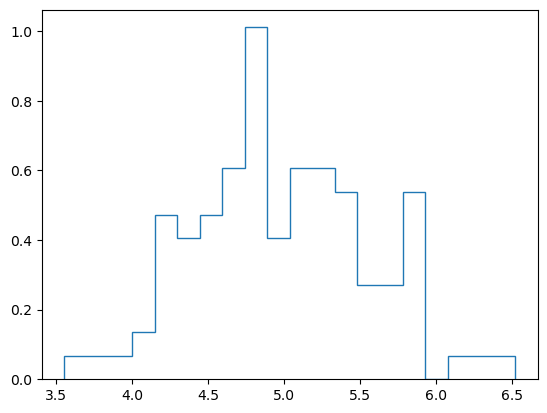

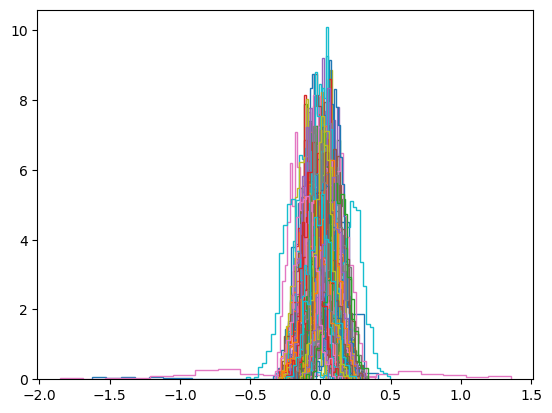

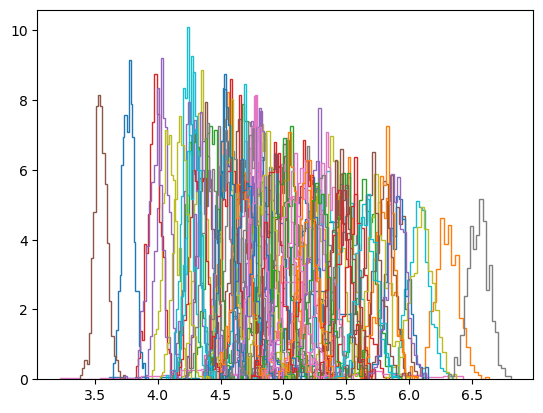

In [10]:
plt.hist(params.frequency[:100], bins=20, density=True, histtype="step")
plt.show()
plt.close()

for ii, post in enumerate(all_fpeak_posteriors):
    plt.hist(post - params.frequency[ii], bins=20, density=True, histtype="step")
plt.show()
plt.close()

for ii, post in enumerate(all_fpeak_posteriors):
    plt.hist(post, bins=20, density=True, histtype="step")
plt.show()
plt.close()

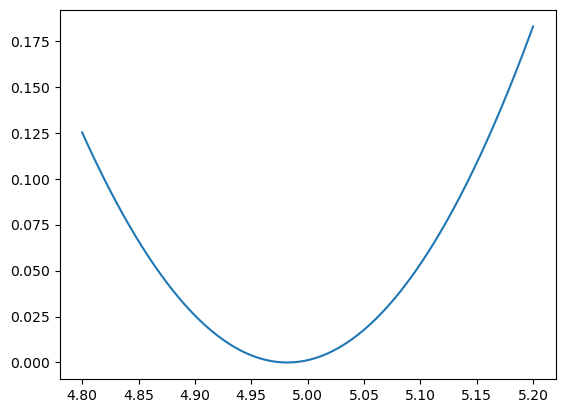

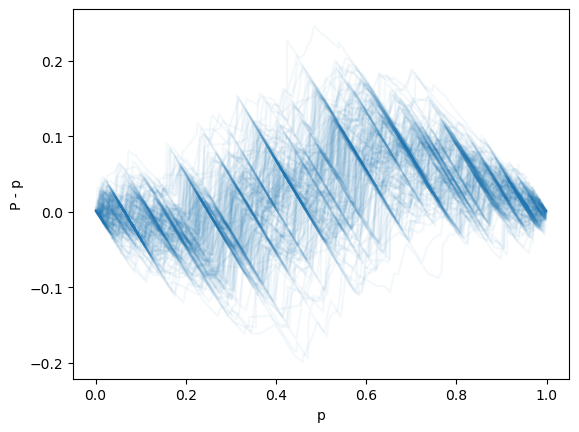

In [11]:
from numpy import random

fpeak_posteriors = np.array(all_fpeak_posteriors)

true_sigma = 0.35

fpeaks = np.linspace(*config["frequency_evaluation_bounds"], config["selection"]["n_points"])

divs = np.array([
    approximate_divergence(fpeak_posteriors.T, mean_frequency, sigma_frequency=true_sigma)
    for mean_frequency in fpeaks
])

# all_divs.append(divs)
plt.plot(fpeaks, divs - min(divs))
plt.show()
plt.close()


yvals = np.sort(np.mean(fpeak_posteriors[:] > params.frequency[:len(all_fpeak_posteriors), None], axis=-1))

for _ in range(250):
    xvals = np.asarray(random.uniform(0, 1, fpeak_posteriors.shape[0]))

    plt.plot(
        np.sort(xvals),
        yvals - np.sort(xvals),
        # color=f"C{ii}",
        color="C0",
        alpha=0.05,
    )
plt.xlabel("p")
plt.ylabel("P - p")
plt.show()
plt.close()

In [4]:
variables = ["amplitude", "frequency", "bandwidth", "phase", "delta_t"]

mcmc_kwargs = config["hba"]

mcmc = MCMC(NUTS(numpyro_model), **mcmc_kwargs)

rng_key = jax.random.PRNGKey(10)

In [5]:
fpeaks = np.linspace(*config["frequency_evaluation_bounds"], config["selection"]["n_points"])

In [6]:
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=20'


def run_mcmc_for_label(label: str, rng_key: jax.Array, mcmc: MCMC, save: bool = True) -> np.ndarray:
    if os.path.exists(f"events_{label}.pkl"):
        print(f"Loading events and truths for {label}")
        with open(f"events_{label}.pkl", "rb") as f:
            events = dill.load(f)[:]
    else:
        print(f"Skipping {label}")
        return None
    stride = 1

    # @jax.jit
    # @partial(jax.pmap, devices=jax.devices('cpu') * stride)
    # @jax.vmap
    @jax.jit
    def run_event(event, rng_key):
    # def run_event(event):
        mcmc.run(rng_key, event.squeeze())
        return mcmc.get_samples()["frequency"]

    fpeak_posteriors = list()
    # rng_key, temp = jax.random.split(rng_key)
    idx = 0
    pbar = tqdm(total=len(events))
    while idx < len(events):
        rng_key, temp = jax.random.split(rng_key)
        fpeak_posteriors.append(run_event(
            events[idx],
            # events[idx:idx+stride],
            temp,
            # jax.random.split(temp, stride),
        ))
        # pbar.update(stride)
        pbar.update(1)
        # idx += stride
        idx += 1
        # print(idx)
    pbar.close()
    # fpeak_posteriors = np.concatenate(fpeak_posteriors)
    # run_event(events, jax.random.split(temp, len(events)))
    # for event, subkey in zip(tqdm(events), jax.random.split(temp, len(events))):
    #     fpeak_posteriors.append(run_event(event, subkey))

    fpeak_posteriors = np.array(fpeak_posteriors)
    if fpeak_posteriors.ndim == 1:
        fpeak_posteriors = fpeak_posteriors.reshape(-1, 500)
    if save:
        np.save(f"fpeak_posteriors_{label}.npy", fpeak_posteriors)
    return fpeak_posteriors, rng_key

In [7]:
from jax import export

def test_function(rng_key, event, mcmc):
    mcmc.run(rng_key, event)
    return mcmc.get_samples()["frequency"]

# exported = export.export(jax.jit(test_function))(jax.ShapeDtypeStruct((2,), np.uint32), jax.ShapeDtypeStruct((513,), np.float64))

# with open("compiled_mcmc.py", "w") as f:
#     f.write(exported.serialize())


# def new_func(rng_key, event):
#     with open("compiled_mcmc.py", "r") as f:
#         exported = export.load(f.read())
#     return exported.deserialize()(rng_key, event)
#     # return (rng_key, event)
# # exported.serialize()

# # dill.load(open("events_0.65_0.pkl", "rb"))[:][0].shape

Loading events and truths for 0.3_8


  0%|          | 0/3552 [00:00<?, ?it/s]

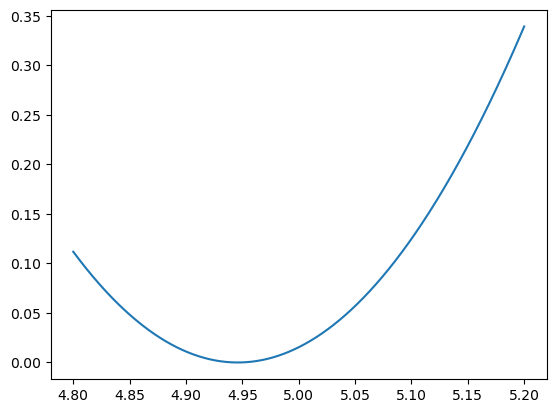

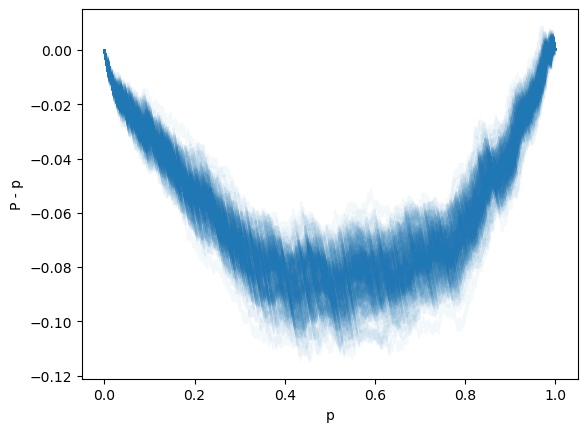

Loading events and truths for 0.4_8


  0%|          | 0/3499 [00:00<?, ?it/s]

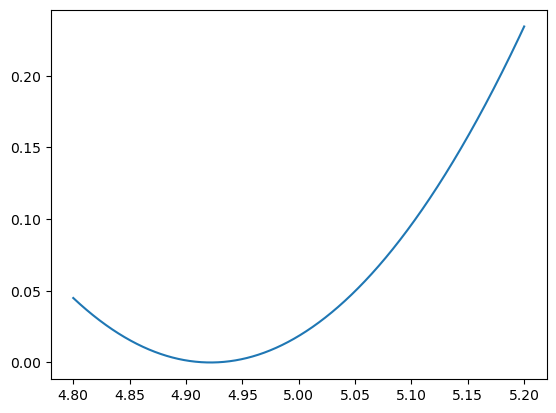

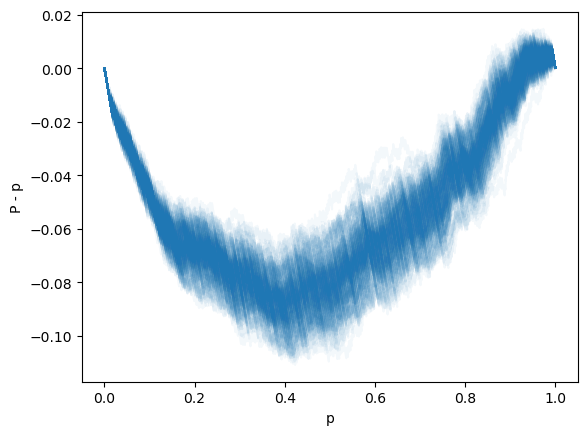

Loading events and truths for 0.6_8


  0%|          | 0/3537 [00:00<?, ?it/s]

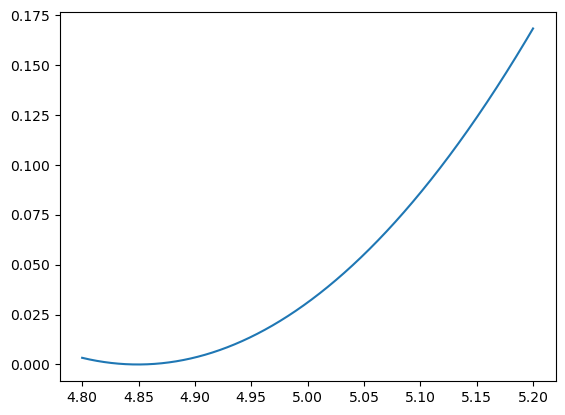

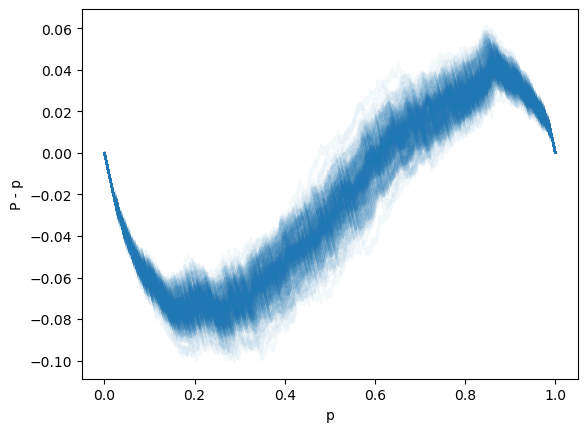

Loading events and truths for 0.8_8


  0%|          | 0/3605 [00:00<?, ?it/s]

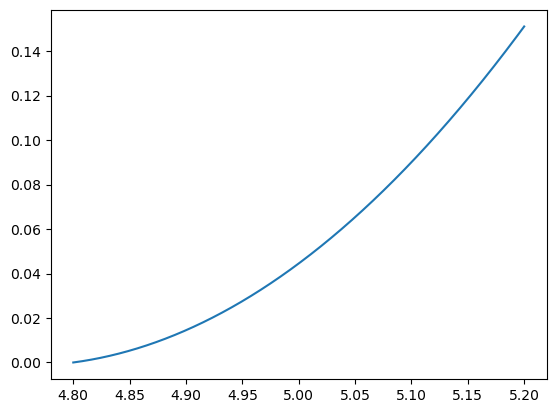

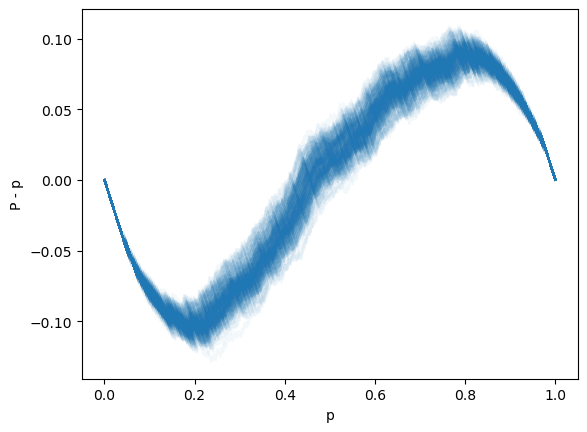

Loading events and truths for 0.35_0


  0%|          | 0/3000 [00:00<?, ?it/s]

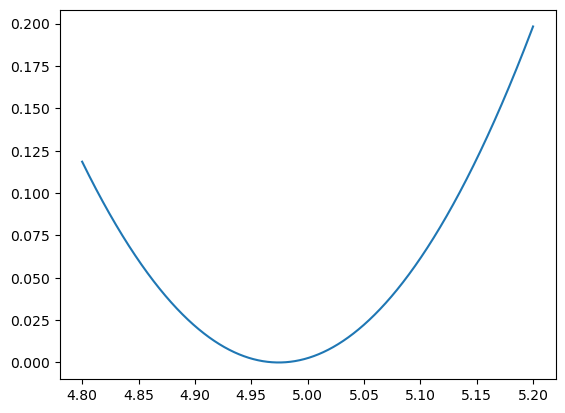

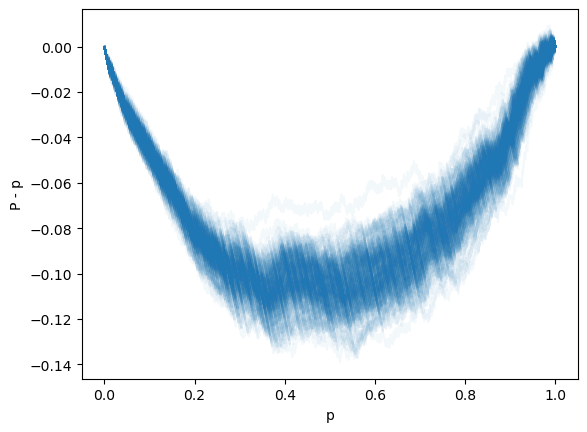

Loading events and truths for 0.45_0


  0%|          | 0/3000 [00:00<?, ?it/s]

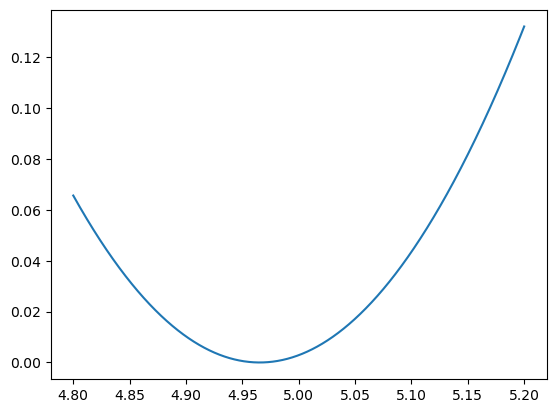

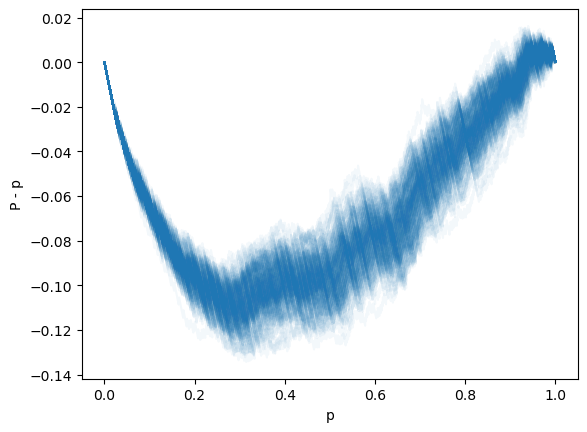

Loading events and truths for 0.65_0


  0%|          | 0/3000 [00:00<?, ?it/s]

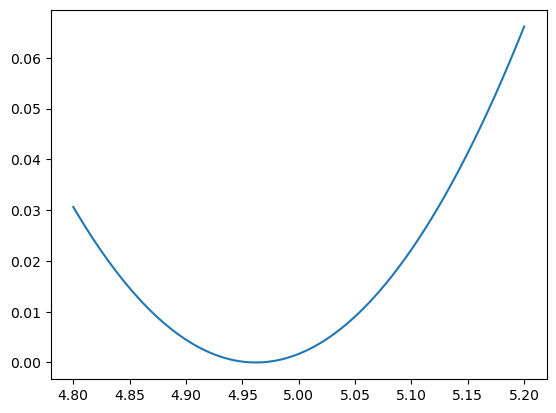

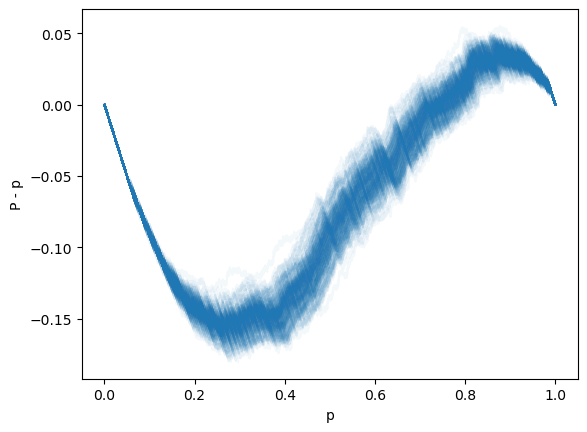

Loading events and truths for 0.85_0


  0%|          | 0/3000 [00:00<?, ?it/s]

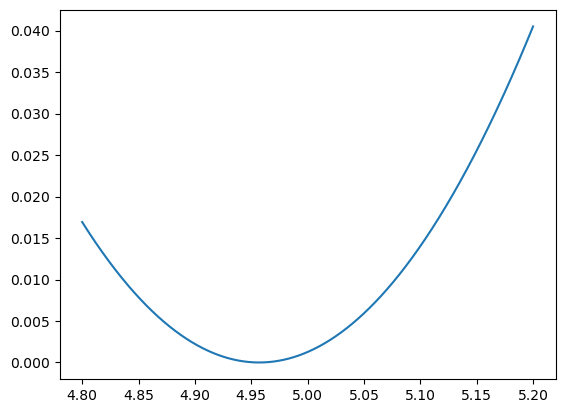

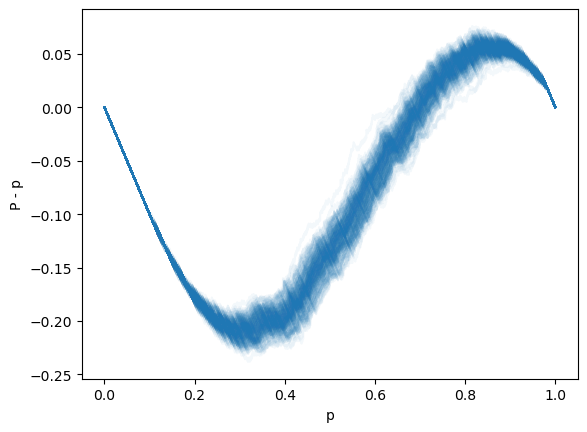

In [8]:
all_divs = list()

for (true_sigma, snr_threshold) in zip(
    config["configurations"]["sigma"], config["configurations"]["threshold"]
):
    label = f"{true_sigma}_{snr_threshold}"

    with jax.log_compiles():
        fpeak_posteriors, rng_key = run_mcmc_for_label(label, rng_key=rng_key, mcmc=mcmc)
    if fpeak_posteriors is None:
        continue

    divs = np.array([
        approximate_divergence(fpeak_posteriors.T, mean_frequency, sigma_frequency=true_sigma)
        for mean_frequency in fpeaks
    ])

    all_divs.append(divs)
    plt.plot(fpeaks, all_divs[-1] - min(all_divs[-1]))
    plt.show()
    plt.close()

    with open(f"params_{label}.pkl", "rb") as f:
        params = dill.load(f)
    fpeak_posteriors = np.load(f"fpeak_posteriors_{label}.npy")


    # plt.hist((params.frequency[:50, None] - fpeak_posteriors[:50]).T, bins=30, density=True, histtype="step")
    # plt.show()
    # plt.close()
    from numpy import random

    yvals = np.sort(np.mean(fpeak_posteriors[:] > params.frequency[:, None], axis=-1))

    for _ in range(250):
        xvals = np.asarray(random.uniform(0, 1, fpeak_posteriors.shape[0]))

        plt.plot(
            np.sort(xvals),
            yvals - np.sort(xvals),
            # color=f"C{ii}",
            color="C0",
            alpha=0.05,
        )
    plt.xlabel("p")
    plt.ylabel("P - p")
    plt.show()
    plt.close()

In [11]:
# fpeak_posteriors = fpeak_posteriors.reshape(-1, 500)
# yvals = np.sort(np.mean(fpeak_posteriors[:] > params.frequency[:-1, None], axis=-1))

# for _ in range(250):
#     xvals = np.asarray(random.uniform(0, 1, fpeak_posteriors.shape[0]))

#     plt.plot(
#         np.sort(xvals),
#         yvals - np.sort(xvals),
#         # color=f"C{ii}",
#         color="C0",
#         alpha=0.05,
#     )
# plt.xlabel("p")
# plt.ylabel("P - p")
# plt.show()
# plt.close()
fpeak_posteriors.shape

(10, 500)

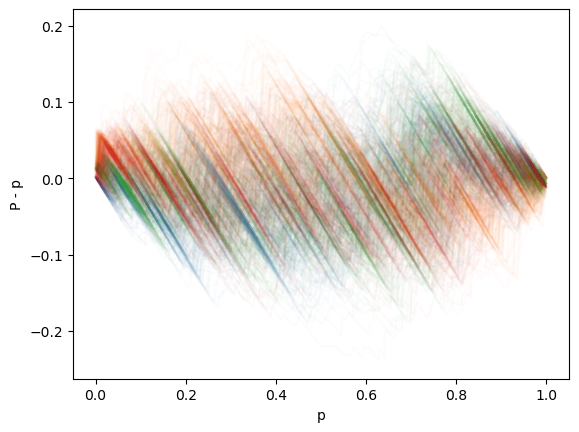

In [15]:
for ii, label in enumerate(["0.35_0", "0.45_0", "0.65_0", "0.85_0"]):

    with open(f"params_{label}.pkl", "rb") as f:
        params = dill.load(f)
    fpeak_posteriors = np.load(f"fpeak_posteriors_{label}.npy")


    # plt.hist((params.frequency[:50, None] - fpeak_posteriors[:50]).T, bins=30, density=True, histtype="step")
    # plt.show()
    # plt.close()
    from numpy import random

    yvals = np.sort(np.mean(fpeak_posteriors[:] > params.frequency[:len(fpeak_posteriors), None], axis=-1))

    for _ in range(250):
        xvals = np.asarray(random.uniform(0, 1, fpeak_posteriors.shape[0]))

        plt.plot(
            np.sort(xvals),
            yvals - np.sort(xvals),
            color=f"C{ii}",
            alpha=0.02,
        )
plt.xlabel("p")
plt.ylabel("P - p")
plt.show()
plt.close()